# A/B tests с Python

## Загрузка библиотек

In [4]:
from scipy.stats import ttest_1samp, mannwhitneyu, shapiro
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Подготовка данных

In [6]:
data = pd.read_excel("./AB_Test_Results.xlsx")
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [13]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [14]:
data.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

Группы разделены поровну.

In [15]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [16]:
data[(data['REVENUE']>0)&(data['VARIANT_NAME'] == 'variant')]

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
139,3331,variant,4.27
149,8110,variant,1.75
540,5845,variant,1.26
1119,8175,variant,5.45
...,...,...,...
9168,443,variant,3.75
9307,2767,variant,2.24
9651,9928,variant,1.25
9725,702,variant,2.92


In [17]:
data[(data['REVENUE']>0)&(data['VARIANT_NAME'] == 'control')]

,USER_ID,VARIANT_NAME,REVENUE
49,6429,control,3.25
152,8607,control,2.99
333,8020,control,9.91
628,6365,control,10.63
758,4445,control,17.05
...,...,...,...
9421,6792,control,41.53
9466,6623,control,1.78
9612,1035,control,0.23
9711,6468,control,2.93


Мы видим, что в контрольной группе количетво покупок на 10% больше.

In [18]:
data[data['VARIANT_NAME'] == 'variant'].describe()

,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


In [19]:
data[data['VARIANT_NAME'] == 'control'].describe()

,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


Мы видим, что в контрольной группе максимальный чек в три раза больше.

In [20]:
data[(data['REVENUE']>0)&(data['VARIANT_NAME'] == 'variant')].describe()

,USER_ID,REVENUE
count,72.000000,72.000000
mean,5306.958333,4.881528
std,3116.544256,9.913973
min,56.000000,0.020000
25%,2707.500000,1.245000
50%,5721.000000,2.170000
75%,7963.750000,3.972500
max,9996.000000,58.630000


In [21]:
data[(data['REVENUE']>0)&(data['VARIANT_NAME'] == 'control')].describe()

,USER_ID,REVENUE
count,80.000000,80.000000
mean,4461.950000,8.037500
std,2826.386242,22.498124
min,124.000000,0.020000
25%,2037.500000,1.515000
50%,4327.000000,2.960000
75%,6636.750000,6.657500
max,9766.000000,196.010000


In [22]:
v = data.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})
v.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [23]:
more_than_one_types = v.query('VARIANT_NAME > 1')

In [24]:
df_new = data[~data.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [25]:
df_new.shape

(6070, 3)

Большое количество пользователей попали в обе группы.

In [26]:
df_new.VARIANT_NAME.value_counts()

variant    3044
control    3026
Name: VARIANT_NAME, dtype: int64

При этом все равно резделены поровну.

In [27]:
alpha = 0.05

st = shapiro(data.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));
st

Distribution is not normal



ShapiroResult(statistic=0.018358170986175537, pvalue=0.0)

In [31]:
control = data.query('VARIANT_NAME == "control"')

test = data.query('VARIANT_NAME == "variant"')

In [40]:
len(control)

4984

In [41]:
len(test)

5016

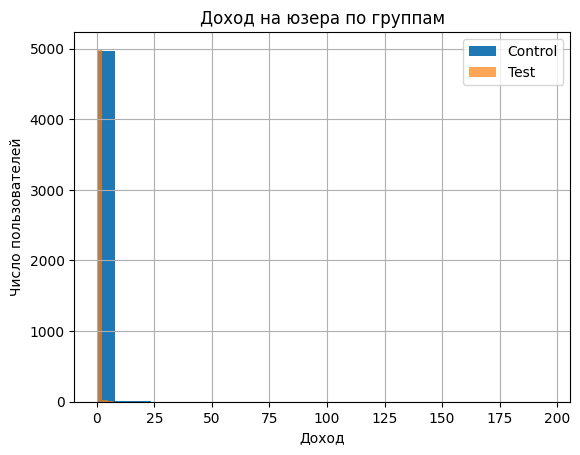

In [43]:
control.REVENUE.hist(bins = 25, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

In [44]:
mw_stats = mannwhitneyu(x=control.REVENUE.values,
                       y=test.REVENUE.values)
mw_stats

MannwhitneyuResult(statistic=12521564.0, pvalue=0.47825247965294926)

# Статистически хначимой разницы не обнаружено, оставляем исходный вариант.

In [45]:
data.loc[(data['REVENUE']>0)&(data['VARIANT_NAME'] == 'control'),'REVENUE'].sum()

643.0

In [46]:
data.loc[(data['REVENUE']>0)&(data['VARIANT_NAME'] == 'variant'),'REVENUE'].sum()

351.47

# Кроме того, суммарная выручка в контрольной группе больше почти в два раза.